This script calculates the yearly likelihood that a 95th percentile wind will occur when antecedent conditions are dry, using climate models.

Dry conditions are defined as a 2-week period where total precipitation is less than 12mm for each grid cell.

The calculation part was run on the server. It can be run locally but will be quite slow and use a lot of memory.

The calculation script can be modified to look at any range of months (e.g. Oct-Nov, Aug-Oct, etc.)

In [1]:
import xarray as xr
import cftime
import pandas as pd
import numpy as np
import netCDF4
import os
import scipy.stats as stats
import matplotlib.colors
# Build some custom colormaps
import matplotlib.colors

# load coordinate dataset
coords = xr.open_dataset('~/wrfinput_d02_coord.nc')

/Users/gt7/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/xarray/backends/cfgrib_.py:28: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  "Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. "
/Users/gt7/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/xarray/backends/plugins.py:68: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [3]:
model_directory = '~/CMIP6/'
model_list = [folder for folder in os.listdir(model_directory) if os.path.isdir(os.path.join(model_directory, folder)) and folder != ".DS_Store"]

In [ ]:
for model in model_list:
    # August Forward
    # change to whatever your file names are
    directory = model_directory+'/'+model+'/pr/historical/'
    pr_dir = directory+'/'+model+'_pr_1981_2013.nc'
    directory = model_directory+'/'+model+'/sfcWind/historical/'
    sfcWind_dir = directory+'/'+model+'_sfcWind_1981_2013.nc'
    pr = xr.open_dataset(pr_dir)
    sfcWind = xr.open_dataset(sfcWind_dir)
    
    # limit data to 1981-2010
    sfcWind = sfcWind.sel(day=slice('1981-01', '2010-12'))
    pr = pr.sel(day=slice('1981-01', '2010-12')) 
    sfcWind_vals = sfcWind.wspd10mean
    pr_vals = pr.prec 
    
    # limit precip to summer (include july, then cut it out, so you get accurate august numbers for a rolling sum)
    months = [7,8,9,10,11]
    time_index = [i for i, month in enumerate(pr_vals.day.dt.month) if month in months]
    new_dataset = pr_vals.isel(day = time_index)
    window = 14
    shifted = new_dataset.rolling(day=window,center=False).construct("window")
    # calculate 2 week rolling precip
    trailprtotal = shifted.sum(dim='window')
    # cut precip to august forward
    months = [8,9,10,11]
    time_index = [i for i, month in enumerate(trailprtotal.day.dt.month) if month in months]
    trailprtotal = trailprtotal.isel(day = time_index)
    
    
    UV = sfcWind_vals
    # set wind percentile
    testing_percentile = .95
    wind_prctiles = UV.quantile(testing_percentile,dim="day")
    # limit wind data to august forward
    months = [8,9,10,11]
    time_index = [i for i, month in enumerate(UV.day.dt.month) if month in months]
    UV = UV.isel(day = time_index)
    # find where wind exceeds 95th percentile
    wd = xr.where(UV > wind_prctiles,1,0)
    
    
    # calculate where precip exceeds chosen threshold (12mm here)
    drycond = xr.where(trailprtotal < 12,1,0)
    wetcond = xr.where(trailprtotal >= 12,1,0)
    wd = wd.rename({'day':'time'})
    drycond = drycond.rename({'day':'time'})
    wetcond = wetcond.rename({'day':'time'})
    
    
    # set empty arrays
    hist_fire_occurences = []
    total_wind_occurences = []
    for i in range(len(wd.groupby('time.year'))):
        testyear = 1981+i
        wd_testing_year = wd.sel(time=wd.time.dt.year.isin([testyear]))
        drycond_testing_year = drycond.sel(time=drycond.time.dt.year.isin([testyear]))
        # Initialize an array of zeros with dimensions of latitude and longitude
        result = np.zeros_like(wd_testing_year.isel(time=0))
        result2 = np.zeros_like(wd_testing_year.isel(time=0))
        for time_index in range(len(wd_testing_year.time)):
            # Get the time slice for both wd_testing_year and drycond_testing_year
            wd_slice = wd_testing_year.isel(time=time_index)
            drycond_slice = drycond_testing_year.isel(time=time_index)
            # Check where both arrays are equal to 1
            mask = (wd_slice == 1) & (drycond_slice == 1)
            # count total dry wind
            dry_wind = wd_slice == 1
            # Count the number of occurrences where the mask is True and increment the result array
            result += mask
            result2 += dry_wind
        # Convert the result array to an xarray DataArray
        result_dataarray = xr.DataArray(result, coords={"lat2d": wd_testing_year.lat2d, "lon2d": wd_testing_year.lon2d}, dims=("lat2d", "lon2d"))
        dw_array = xr.DataArray(result2, coords={"lat2d": wd_testing_year.lat2d, "lon2d": wd_testing_year.lon2d}, dims=("lat2d", "lon2d"))
        hist_fire_occurences.append(result_dataarray)
        total_wind_occurences.append(dw_array)
        
    # turn into array and save data
    hist_fire_occurences = xr.concat(hist_fire_occurences,dim='newyear')
    hist_fire_occurences_mean = hist_fire_occurences.mean(dim='newyear')
    hist_wind_occurence = xr.concat(total_wind_occurences,dim='newyear')
    data_dict_hist = {'total_wind':hist_wind_occurence,'dry_wind_mean_per_year': hist_fire_occurences_mean,'dry_wind_total':hist_fire_occurences}
    dataset_hist = xr.Dataset(data_dict_hist)
    efwh_file = '/your_directory/hist_dry_wind.nc'
    dataset_hist.to_netcdf(efwh_file)
    
    
    ## repeat for future models
    
    directory = model_directory+'/'+model+'/pr/ssp370/'
    pr_dir = directory+'/'+model+'_pr_2065_2099.nc'
    directory = model_directory+'/'+model+'/sfcWind/ssp370/'
    sfcWind_dir = directory+'/'+model+'_sfcWind_2065_2099.nc'
    pr = xr.open_dataset(pr_dir)
    sfcWind = xr.open_dataset(sfcWind_dir)
    
    
    sfcWind = sfcWind.sel(day=slice('2070-01', '2099-12'))
    pr = pr.sel(day=slice('2070-01', '2099-12'))
    sfcWind_vals = sfcWind.wspd10mean
    pr_vals = pr.prec
    
    
    months = [7,8,9,10,11]
    time_index = [i for i, month in enumerate(pr_vals.day.dt.month) if month in months]
    new_dataset = pr_vals.isel(day = time_index)
    window = 14
    shifted = new_dataset.rolling(day=window,center=False).construct("window")
    trailprtotal = shifted.sum(dim='window')
    months = [8,9,10,11]
    time_index = [i for i, month in enumerate(trailprtotal.day.dt.month) if month in months]
    trailprtotal = trailprtotal.isel(day = time_index)
    
    UV = sfcWind_vals
    months = [8,9,10,11]
    time_index = [i for i, month in enumerate(UV.day.dt.month) if month in months]
    UV = UV.isel(day = time_index)
    wd = xr.where(UV > wind_prctiles,1,0)
    
    drycond = xr.where(trailprtotal < 12,1,0)
    wetcond = xr.where(trailprtotal >= 12,1,0)
    wd = wd.rename({'day':'time'})
    drycond = drycond.rename({'day':'time'})
    wetcond = wetcond.rename({'day':'time'})
    
    # check wind before dry for each year
    
    fut_fire_occurences = []
    total_wind_occurences = []
    for i in range(len(wd.groupby('time.year'))):
        testyear = 2070+i
        wd_testing_year = wd.sel(time=wd.time.dt.year.isin([testyear]))
        drycond_testing_year = drycond.sel(time=drycond.time.dt.year.isin([testyear]))
    
        # Initialize an array of zeros with dimensions of latitude and longitude
        result = np.zeros_like(wd_testing_year.isel(time=0))
        result2 = np.zeros_like(wd_testing_year.isel(time=0))
        for time_index in range(len(wd_testing_year.time)):
            # Get the time slice for both wd_testing_year and drycond_testing_year
            wd_slice = wd_testing_year.isel(time=time_index)
            drycond_slice = drycond_testing_year.isel(time=time_index)
    
            # Check where both arrays are equal to 1
            # count total dry wind
            mask = (wd_slice == 1) & (drycond_slice == 1)
            
            dry_wind = wd_slice == 1
    
            # Count the number of occurrences where the mask is True and increment the result array
            result += mask
            
            result2 += dry_wind
        # Convert the result array to an xarray DataArray
        result_dataarray = xr.DataArray(result, coords={"lat2d": wd_testing_year.lat2d, "lon2d": wd_testing_year.lon2d}, dims=("lat2d", "lon2d"))
        dw_array = xr.DataArray(result2, coords={"lat2d": wd_testing_year.lat2d, "lon2d": wd_testing_year.lon2d}, dims=("lat2d", "lon2d"))
        fut_fire_occurences.append(result_dataarray)
        total_wind_occurences.append(dw_array)
    fut_fire_occurences = xr.concat(fut_fire_occurences,dim='newyear')
    fut_fire_occurences_mean = fut_fire_occurences.mean(dim='newyear')
    
    fut_wind_occurence = xr.concat(total_wind_occurences,dim='newyear')
    
    # instead of calculating occurences per year, count dry wind occurences/wind occurences
    
    data_dict_fut = {'total_wind':fut_wind_occurence,'dry_wind_mean_per_year': fut_fire_occurences_mean,'dry_wind_total':fut_fire_occurences}
    dataset_fut = xr.Dataset(data_dict_fut)
    efwh_file = '/your_directory/fut_dry_wind.nc'
    dataset_fut.to_netcdf(efwh_file)


## Plotting

In [2]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
import cftime
import pandas as pd
import cftime
import numpy as np
import netCDF4
import os
import cartopy.feature as cfeature
import scipy.stats as stats
from netCDF4 import Dataset
import h5py
from matplotlib.ticker import MultipleLocator
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER

In [3]:
model_directory = '/model_directory/'
model_list = [folder for folder in os.listdir(model_directory) if os.path.isdir(os.path.join(model_directory, folder)) and folder != ".DS_Store"]
coords = xr.open_dataset('~/wrfinput_d02_coord.nc')

In [4]:
# Build some custom colormaps
segment_map_new = matplotlib.colors.ListedColormap(["darkslateblue","steelblue","teal","darkseagreen","lightgreen","lemonchiffon","khaki","coral","indianred","firebrick"])

### Historical Dry Wind Likelihood

/Users/gt7/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
/Users/gt7/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


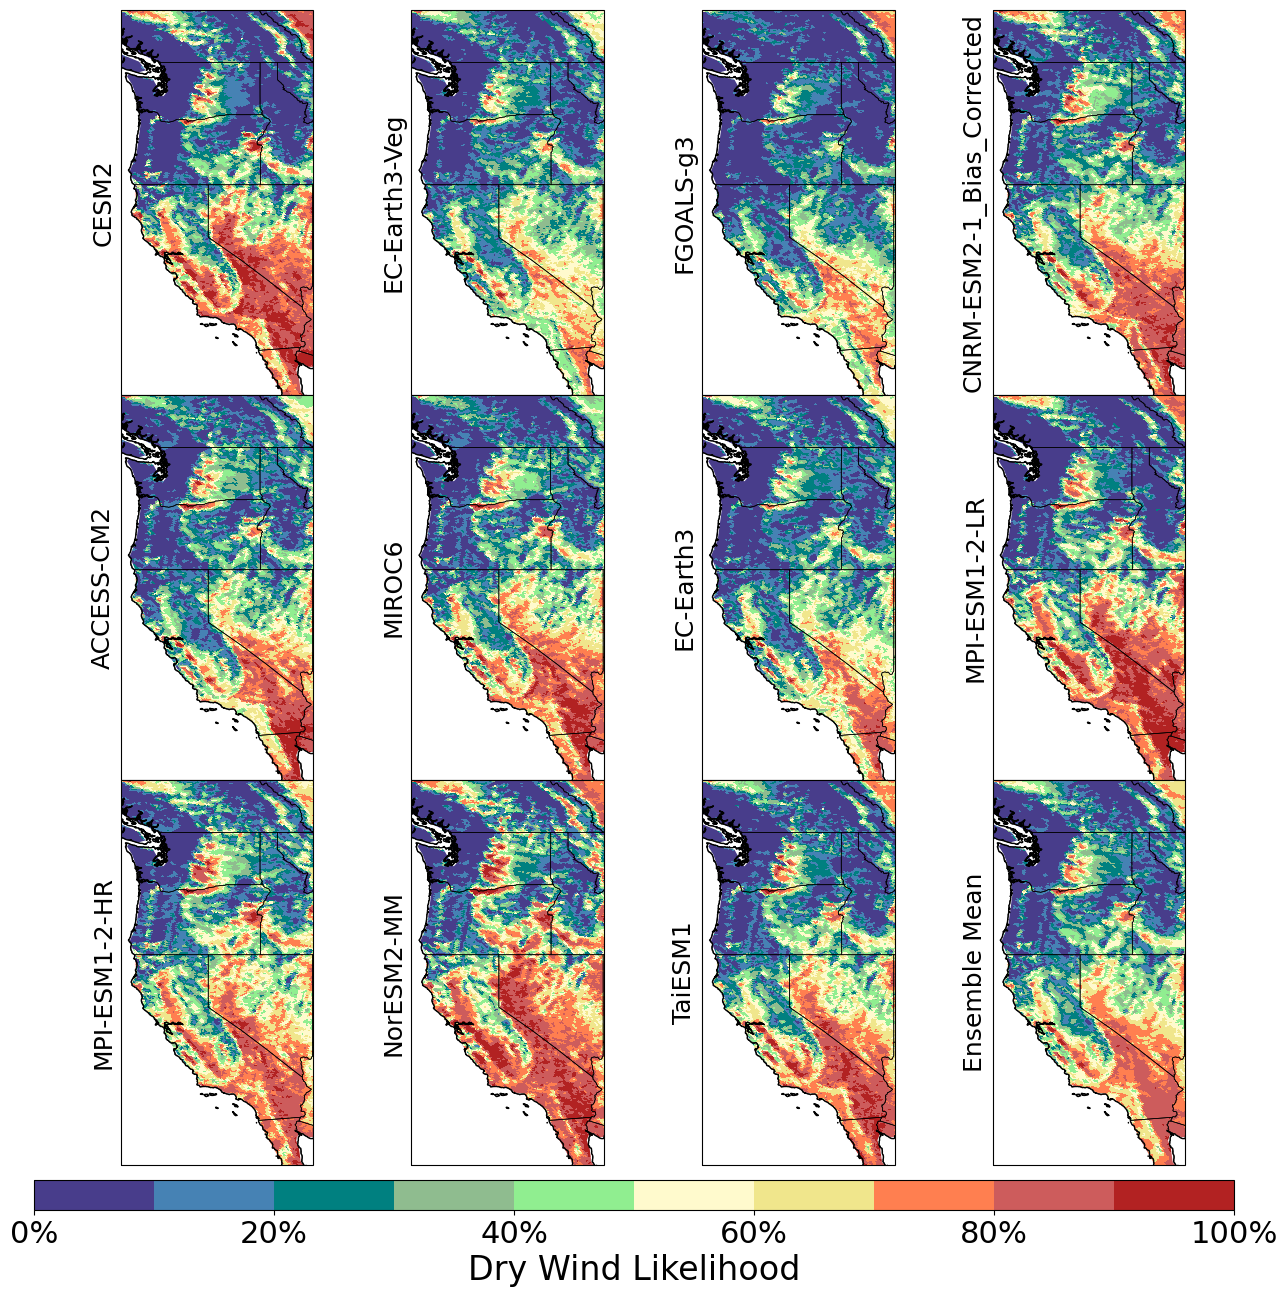

In [5]:
fig,ax = plt.subplots(3,4,figsize=[15,15],constrained_layout=True)
bin_edges = np.arange(0, 1, .1)
all_fw = []
for model in model_list:
    fire_weather_file = model_directory+'/'+model+'/'+model+'_hist_dry_wind.nc'
    fw_dataset = xr.open_dataset(fire_weather_file)
    total_wind = fw_dataset.total_wind.sum(dim='newyear')
    dry_wind = fw_dataset.dry_wind_total.sum(dim='newyear')
    proportion = dry_wind/total_wind
    all_fw.append(proportion)
all_fw = xr.concat(all_fw, dim='model')
ensemble_mean = all_fw.mean(dim='model')
all_fw = xr.concat([all_fw,ensemble_mean],dim='model')
model_list.append('Ensemble Mean')

for x,model in enumerate(model_list):
    fw_average = all_fw[x]
    ax = plt.subplot(3, 4, x+1, projection=ccrs.PlateCarree())
    im = ax.pcolormesh(coords['lon2d'],coords['lat2d'],fw_average,cmap=segment_map_new)
    ocean = cfeature.NaturalEarthFeature('physical', 'ocean', '110m', edgecolor='face', facecolor='white')
    ax.add_feature(ocean)
    #plt.colorbar()
    #plt.title(model)
    ax.coastlines()
    ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=.5)
    ax.set_ylim(30,52)
    ax.set_xlim(-125,-114)
    ax.set_ylabel(model,fontsize=18)
    ax.yaxis.set_label_position("left")
    ax.tick_params(axis='y')
    ax.set_xticks([])
    ax.set_yticks([])

#plt.colorbar(im,fraction=0.075, pad=0.04)
fig.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
cbar_ax = fig.add_axes([0.1, 0.08, 0.8, 0.02]) 
cbar = fig.colorbar(im,cax=cbar_ax,orientation='horizontal')
new_ticks = np.linspace(0, 1, 6)  # Adjust the number of ticks as needed
new_tick_labels = [f'{int(t*100)}%' for t in new_ticks]

cbar.set_ticks(new_ticks)
cbar.set_ticklabels(new_tick_labels)
cbar.ax.tick_params(labelsize=22) 
cbar.set_label('Dry Wind Likelihood',fontsize=24)

plt.show()

## Calculate future change and significance

In [6]:
model_directory = '/model_directory/'
model_list = [folder for folder in os.listdir(model_directory) if os.path.isdir(os.path.join(model_directory, folder)) and folder != ".DS_Store"]

In [7]:
%%time
from scipy.stats import chi2_contingency

#model_list.remove('Ensemble Mean')
all_sigs = []
all_diffs = []
for model in model_list:
    fire_weather_file = model_directory+'/'+model+'/'+model+'_hist_dry_wind.nc'
    fw_dataset = xr.open_dataset(fire_weather_file)
    all_wind_hist = fw_dataset.total_wind
    dry_wind_hist = fw_dataset.dry_wind_total
    proportion_hist = dry_wind_hist.sum(dim='newyear')/all_wind_hist.sum(dim='newyear')
    
    # future
    
    fire_weather_file = model_directory+'/'+model+'/'+model+'_fut_dry_wind.nc'
    fw_dataset = xr.open_dataset(fire_weather_file)
    all_wind_fut = fw_dataset.total_wind
    dry_wind_fut = fw_dataset.dry_wind_total
    proportion_fut = dry_wind_fut.sum(dim='newyear')/all_wind_fut.sum(dim='newyear')
    
    
    fire_diff = proportion_fut - proportion_hist
    
    # so you need to sum the total yes and total no, so each coordinate has a count of wind first and a count of rain first
    #historical
    
    # dry wind vs wet wind
    
    # Historical
    # historical dry wind
    hist_dry_wind = dry_wind_hist==1
    hist_dry_wind = hist_dry_wind.sum(dim='newyear')    
    # wet wind
    # where all_wind=1 but dry_wind=0
    hist_wet_wind = all_wind_hist.where(dry_wind_hist==0).fillna(0)
    hist_wet_wind = hist_wet_wind.sum(dim='newyear')
    
    # Future
    
    fut_dry_wind = dry_wind_fut==1
    fut_dry_wind = fut_dry_wind.sum(dim='newyear')    
    # wet wind
    # where all_wind=1 but dry_wind=0
    fut_wet_wind = all_wind_fut.where(dry_wind_fut==0).fillna(0)
    fut_wet_wind = fut_wet_wind.sum(dim='newyear')
    
    all_data = []
    all_data.append(hist_dry_wind)
    all_data.append(fut_dry_wind)
    all_data.append(hist_wet_wind)
    all_data.append(fut_wet_wind)
    
    all_data_concat = xr.concat(all_data,dim='newdim')
    pvals = xr.DataArray(coords=(all_data_concat.lat2d, all_data_concat.lon2d))  
    for x in range(len(all_data_concat.lat2d)):
        for y in range(len(all_data_concat.lon2d)):
            testdata = all_data_concat.isel(lat2d=x, lon2d=y)
            newtest = testdata.values.reshape(2, 2)
            epsilon = 1e-10
            newtest = newtest + epsilon
            # Perform chi-squared test
            chi2, p_value, _, _ = chi2_contingency(newtest)
            pvals[x, y] = p_value

    sig_vals = pvals<.1
    #sig_diffs = sig_vals*fire_diff
    all_sigs.append(sig_vals)
    all_diffs.append(fire_diff)

all_diffs_new = xr.concat(all_diffs,dim='model')
ensemble_mean = all_diffs_new.mean(dim='model')
all_diffs_new = xr.concat([all_diffs_new,ensemble_mean],dim='model')
model_list.append('Ensemble Mean')
all_sigs = xr.concat(all_sigs,dim='model')
all_sigs_new = xr.concat([all_sigs,ensemble_mean],dim='model')

CPU times: user 13min 24s, sys: 14.4 s, total: 13min 38s
Wall time: 17min 11s


In [8]:
data_dict= {'all_diffs_new': all_diffs_new, 'all_sigs': all_sigs_new}
dataset_hist = xr.Dataset(data_dict)
save_dir_hist = '/.../sig_data.nc'
dataset_hist.to_netcdf(save_dir_hist)

In [15]:
model_directory = '/model_directory/'
model_list = [folder for folder in os.listdir(model_directory) if os.path.isdir(os.path.join(model_directory, folder)) and folder != ".DS_Store"]

In [ ]:
# Mark whether at least half the models agree (6 right now, can be changed)

In [16]:
dataset_hist = xr.open_dataset('/.../sig_data.nc')
all_diffs_new = dataset_hist.all_diffs_new
all_sigs = dataset_hist.all_sigs

sig_sum = all_sigs.sum(dim='model')
half_count = sig_sum>=6
model_list.append('Ensemble Mean')

In [17]:
all_sigs_new = all_sigs.drop_sel(model=11)

## Method 1

In [18]:
segment_map3 = matplotlib.colors.ListedColormap(["royalblue","cornflowerblue","lightskyblue","lightcyan","mistyrose","lightcoral","indianred","firebrick"])

/Users/gt7/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1508: UserWarning: linewidths is ignored by contourf
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/Users/gt7/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1508: UserWarning: The following kwargs were not used by contour: 'color'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/Users/gt7/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
/Users/gt7/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


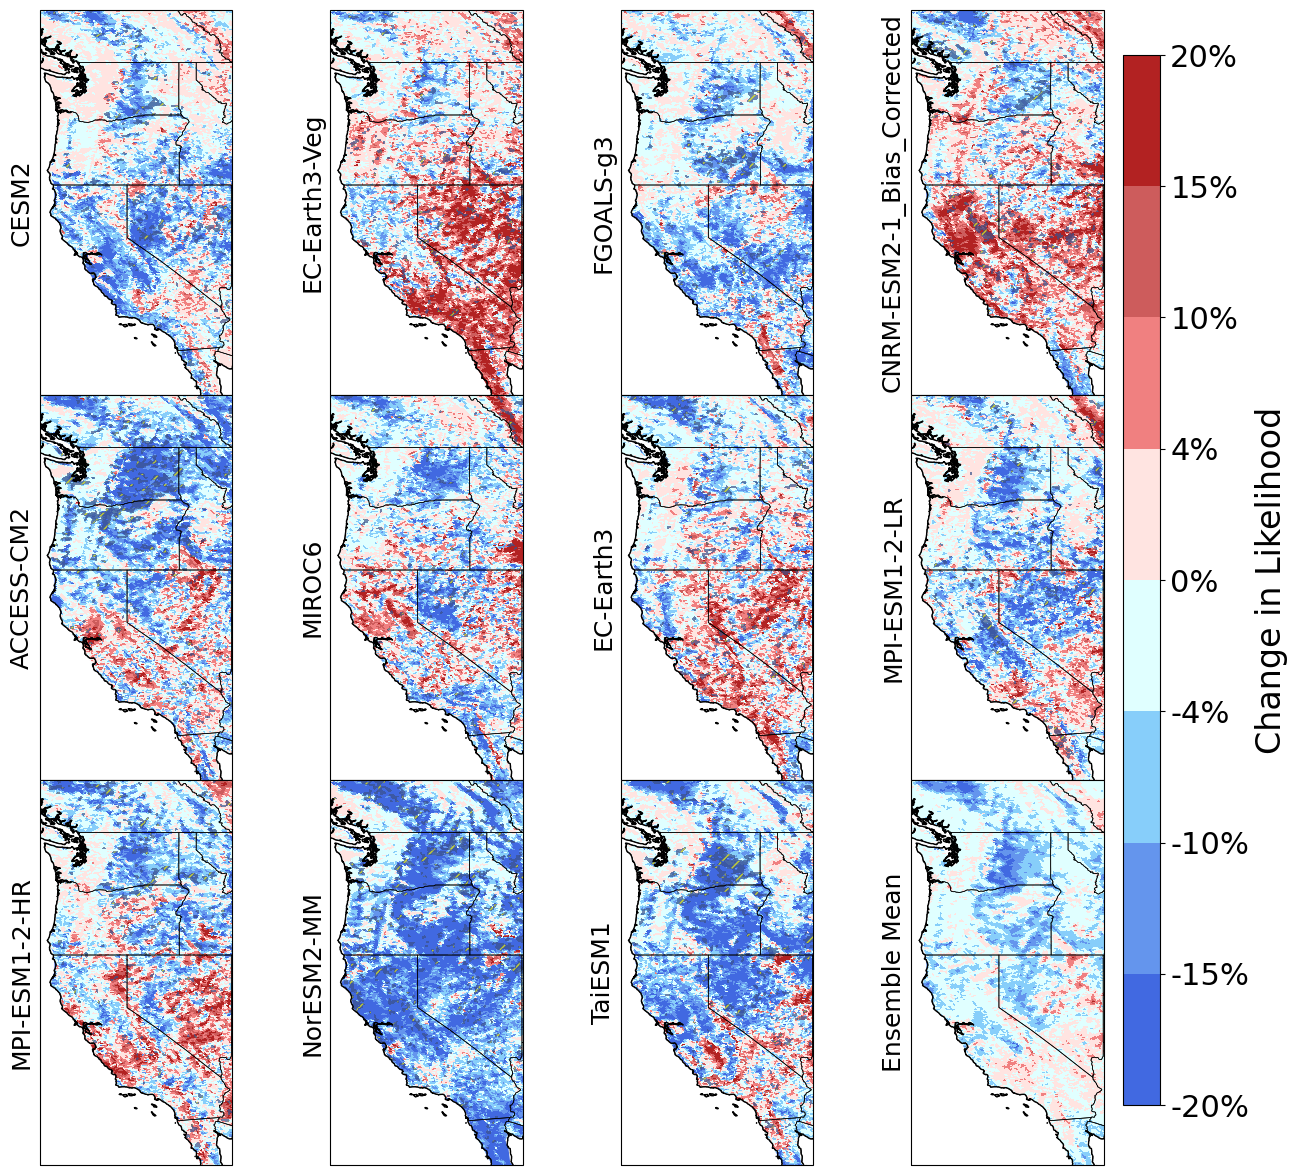

In [19]:
fig,ax = plt.subplots(3,4,figsize=[15,15],constrained_layout=True)
for i, model in enumerate(model_list):
    fire_diff = all_diffs_new[i]
    if i < 11:
        sig_vals = all_sigs[i]
    else:
        sig_vals = half_count

    ax = plt.subplot(3, 4, i + 1, projection=ccrs.PlateCarree())
    im = ax.pcolormesh(coords['lon2d'], coords['lat2d'], fire_diff, cmap=segment_map3, vmax=0.2, vmin=-0.2)
    
    masked_array = np.where(sig_vals.values, 1, np.nan)
    # Use plt.contourf for hatching
    cs = plt.contourf(coords['lon2d'], coords['lat2d'], masked_array, hatches=['//'], alpha=.7, linewidths=2,color='none')
    
    # Define colors for hatching
    hatch_colors = ['yellow']

    # Set the color of hatching for each level
    for j, collection in enumerate(cs.collections):
        collection.set_edgecolor(hatch_colors[j % len(hatch_colors)])
    
    # Remove the colored line around the levels
    for collection in cs.collections:
        collection.set_linewidth(.0)
    
    ocean = cfeature.NaturalEarthFeature('physical', 'ocean', '110m', edgecolor='face', facecolor='white')
    ax.add_feature(ocean)
    ax.coastlines()
    ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
    ax.set_ylim(30, 52)
    ax.set_xlim(-125, -114)
    ax.set_ylabel(model, fontsize=18)
    ax.yaxis.set_label_position("left")
    ax.tick_params(axis='y')
    ax.set_xticks([])
    ax.set_yticks([])

fig.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
cbar_ax = fig.add_axes([0.88, 0.15, 0.025, 0.7])
cbar = plt.colorbar(im, cax=cbar_ax)
new_ticks = np.linspace(-.2, .2, 9)  # Adjust the number of ticks as needed
new_tick_labels = [f'{int(t*100)}%' for t in new_ticks]
cbar.set_ticks(new_ticks)
cbar.set_ticklabels(new_tick_labels)
cbar.set_label('Change in Likelihood', rotation=90,fontsize=24)
cbar.ax.tick_params(labelsize=22) 

plt.show()

## Method 2

/Users/gt7/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
/Users/gt7/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


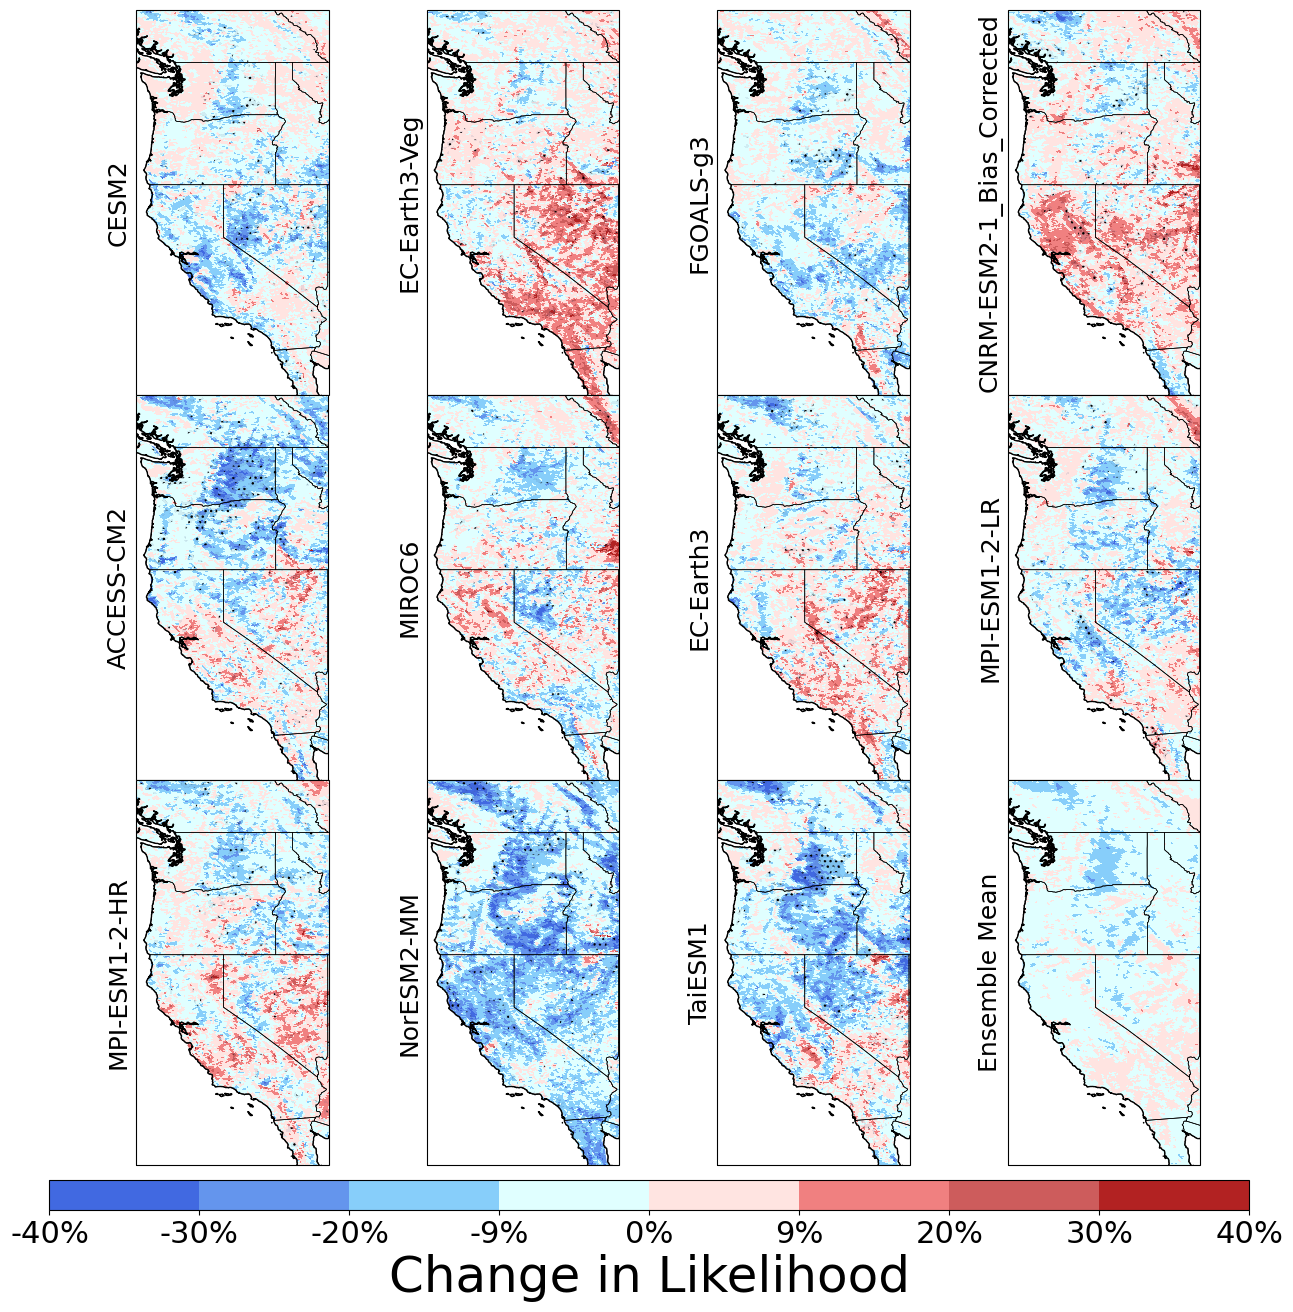

In [20]:
fig,ax = plt.subplots(3,4,figsize=[15,15],constrained_layout=True)
for i, model in enumerate(model_list):
    fire_diff = all_diffs_new[i]
    if i < 11:
        sig_vals = all_sigs[i]
    else:
        sig_vals = half_count

    ax = plt.subplot(3, 4, i + 1, projection=ccrs.PlateCarree())
    im = ax.pcolormesh(coords['lon2d'], coords['lat2d'], fire_diff, cmap=segment_map3, vmax=0.4, vmin=-0.4)
    
    masked_array = np.where(sig_vals.values, 1, np.nan)
    plt.contourf(coords['lon2d'], coords['lat2d'], masked_array, hatches=['...'], alpha=0.1, linewidths=0.1,color='white')
    # Define colors for hatching
    hatch_colors = ['yellow']
    
    #cs = plt.contourf(coords['lon2d'], coords['lat2d'], masked_array, hatches=['//'], alpha=.7, linewidths=2,color='none')
    

    # Set the color of hatching for each level
    for j, collection in enumerate(cs.collections):
        collection.set_edgecolor(hatch_colors[j % len(hatch_colors)])
    
    # Remove the colored line around the levels
    for collection in cs.collections:
        collection.set_linewidth(.0)
    
    ocean = cfeature.NaturalEarthFeature('physical', 'ocean', '110m', edgecolor='face', facecolor='white')
    ax.add_feature(ocean)
    ax.coastlines()
    ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
    ax.set_ylim(30, 52)
    ax.set_xlim(-125, -114)
    ax.set_ylabel(model, fontsize=18)
    ax.yaxis.set_label_position("left")
    ax.tick_params(axis='y')
    ax.set_xticks([])
    ax.set_yticks([])

fig.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
cbar_ax = fig.add_axes([0.1, 0.08, 0.8, 0.02]) 
cbar = plt.colorbar(im,ticks=[-40, -30, -20, -10, 0, 10, 20, 30, 40], cax=cbar_ax, orientation='horizontal')
new_ticks = np.linspace(-.4, .4, 9)  # Adjust the number of ticks as needed
new_tick_labels = [f'{int(t*100)}%' for t in new_ticks]
cbar.set_ticks(new_ticks)
cbar.set_ticklabels(new_tick_labels)
cbar.set_label('Change in Likelihood',fontsize=36)
cbar.ax.tick_params(labelsize=22) 

plt.show()